# Indeed.com - Job Description Analyis
I will use NLP (natural language processing) to analyse job adverts scraped from the uk.Indeed.com jobs website

I will focus on UK based jobs in the data industry, mainly in Scottish companies to start with, keeping the data gathering steps manageable, possibly expanding the study to the rest of the UK later.

I will write my own web scraper using the Requests and BeautifulSoup libraries.  I plan to process the text data using the nltk library

## Motivation
Suppose I am running a hypothetical data analytics company.  I have been approached by another company who are hoping to build and recruit a data analytics team.  Since they don't have an existing data analytics team, I have been given a list of skills and experience they think they need.  My challenge is to classify what job title they should be marketing their vacancy for.  Should it be a Data Scientist, or a Data Engineer etc.

I am also (hypothetically) working with candidates to best tailor their CV, project portfolio etc to optimise for the things that data industry recruiters are looking for.  My study should be able to generate a list of the key things for each of the major data professions.

## Sections (rough outline)
- Scrape the data
- Data cleaning
- Data exploration
  - Extracting the list of top skills requirements for each of the main disciplines
  - Picking out common phrases to reference in an optimised CV
- Feature engineering
  - Job description length
  - Years of experience mentioned
  - Salary range (if enough data available)
  - Key tech stack tools included, cloud platforms, databases, NLP, dashboards etc.
  - Mentioning remote, flexible working etc
- Model Building
  - Classifier for labelling a job ad, with the most approproate job title.
  - Na   svieve Bayes
- Model Tuning



In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import pprint
import os
import indeed.IndeedScraper as ind
from wordcloud import WordCloud


# Scrape the data

In [2]:
# Manually trigger running the scraper or just loading existing data
scrape_new = False

f_name = 'data/data.csv'
if scrape_new or not os.path.isfile(f_name):
    ind.batch_scrape([('Data Scientist', 'Scotland'),
                      ('Data Engineer', 'Scotland'),
                      ('Data Analyst', 'Scotland'),
                      ('Business Analyst', 'Scotland'),
                      ('Machine Learning Engineer', 'Scotland'),
                      ('Machine Learning', 'Scotland'),
                      ('Artificial Intelligence', 'Scotland'),
                      ('AI', 'Scotland'),
                      ('Data', 'Scotland')],
                     pages=20,
                     delay=5,
                     append=False)
    df = pd.read_csv(f_name, index_col=0)
else:
    df = pd.read_csv(f_name, index_col=0)
    print(f'Data read from .csv ({len(df)} rows, {len(df.columns)} columns)')

Data read from .csv (998 rows, 13 columns)


In [3]:
df.shape

(998, 13)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998 entries, 0 to 997
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             998 non-null    object
 1   id                998 non-null    object
 2   company           998 non-null    object
 3   url               998 non-null    object
 4   location          998 non-null    object
 5   summary           998 non-null    object
 6   date              998 non-null    object
 7   description       998 non-null    object
 8   description_html  998 non-null    object
 9   page_format       998 non-null    int64 
 10  salary            129 non-null    object
 11  query_title       998 non-null    object
 12  query_loc         998 non-null    object
dtypes: int64(1), object(12)
memory usage: 109.2+ KB


# Data cleaning

## Drop duplicates
Some (not all) duplicates are removed by the scraping routine.

Check if there are any duplicates in the "id" column.  Since the scraped csv data was simply multiple search queries, then results appended into one big csv file.  It's possible for there to be some duplicates where id numbers are the same, between the multiple batches.

In [5]:
df.duplicated('id').sum()

293

In [6]:
df = df.drop_duplicates('id', ignore_index=True)
df.shape

(705, 13)

## Fix column dtypes
Turn query_title into categorical column

In [7]:
df['query_title'] = df['query_title'].astype('category')

Switch text columns to lowercase

In [8]:
df['title'] = df['title'].str.lower()
df['description'] = df['description'].str.lower()

## Crop the "new" prefix
Looks like some of the job titles were prefixed with "new...".  This will interfere with the word matching so let's remove it.

In [9]:
mask = df.title.str.contains('^new', regex=True)
df[mask].title.iloc[:10].tolist()

['newdata science lecturer (international development)',
 'newanalytics coordinator',
 'newreporting analyst',
 'newpolicy analyst',
 'newwind analyst',
 'newdata quality & remediation analyst',
 'newbusiness information analyst- business coordinator',
 'newdata analyst role within flow cytometry lab',
 'newinformation analyst (planning and insight)',
 'newbusiness analyst']

Crop the prefix off the title value

In [10]:
df.title = df.title.agg(lambda x: re.sub('^new','',x,1))

# Check that none with prefix still exist
mask = df.title.str.contains('^new', regex=True)
df[mask].title.iloc[:10].tolist()

[]

# Data exploration

Try a few things
- Wordcloud
- nltk freqdistoud

## Wordcloud
Create a wordcloud for all job description text.

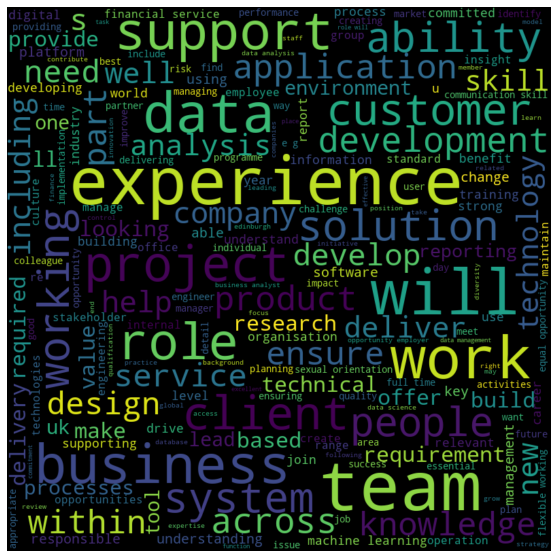

In [11]:
# Read the whole text.
text = ' '.join(df['description'].tolist())

# Generate a word cloud image
wordcloud = WordCloud(max_font_size=100, width=800, height=800).generate(text)
WordCloud()
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


Create a wordcloud for all jobtitle text only

Analyst, 

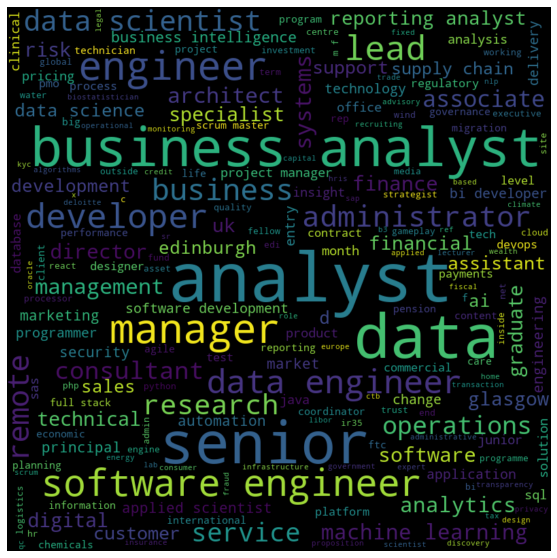

In [12]:
# Read the job title only]
text = ' '.join(df['title'].tolist())

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
wordcloud = WordCloud(max_font_size=100, width=800, height=800).generate(text)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


## Try using nltk freqdist
Start with just looking at the first job data entry

In [13]:
from nltk.probability import FreqDist

text = df.description.iloc[0]
text = nltk.word_tokenize(text)
fdist = FreqDist(text)

[print(x) for x in fdist.most_common(10)];

('and', 34)
(',', 27)
('to', 24)
('data', 19)
('you', 14)
('the', 13)
('a', 12)
('’', 12)
('of', 12)
('as', 11)


Lots of useless words in that list.  Lets remove all the standard English Stopwords

In [14]:
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))

In [15]:
text = [x for x in text if x not in stop_words]
fdist = FreqDist(text)

[print(x) for x in fdist.most_common(10)];

(',', 27)
('data', 19)
('’', 12)
('experience', 10)
('.', 8)
('business', 7)
('analysis', 6)
('using', 5)
('science', 5)
('methods', 4)


This looks like it still includes punctuation, remove these entries to get a clearer picture of the top words in the dataset

In [16]:
text = [x for x in text if (x not in stop_words) & (x.isalpha())]
fdist = FreqDist(text)

[print(x) for x in fdist.most_common(10)];

('data', 19)
('experience', 10)
('business', 7)
('analysis', 6)
('using', 5)
('science', 5)
('methods', 4)
('work', 3)
('including', 3)
('also', 3)


# Information extraction
The objective here should be to try to extract info on skills.  So we can build a classifier that looks at the advert description text, and based on the list of skills identified

## Tokenisation

In [17]:
def ie_preprocess(document):
    # Use list comprehension to 
#     sentences = [p for p in text.split('\n') if p]
    paras = []
    for para in document.split('\n'):
        paras.extend(nltk.sent_tokenize(para))
#         paras.append(para)
    sentences = paras    
    sentences = [nltk.word_tokenize(sent) for sent in sentences]
#     sentences = [nltk.pos_tag(sent) for sent in sentences]
    return sentences
    
# Start from scratch
text = df.description.iloc[0]

a = ie_preprocess(text)
# pp = pprint.PrettyPrinter()
# pp.pprint(a)
a


[['join', 'us', 'as', 'a', 'data', 'scientist'],
 ['you',
  '’',
  'll',
  'be',
  'identifying',
  'and',
  'working',
  'with',
  'large',
  ',',
  'complex',
  'data',
  'sets',
  'to',
  'solve',
  'difficult',
  ',',
  'non-routine',
  'analysis',
  'problems',
  ',',
  'applying',
  'advanced',
  'analytical',
  'methods',
  'as',
  'needed'],
 ['we',
  '’',
  'll',
  'look',
  'to',
  'you',
  'to',
  'actively',
  'participate',
  'in',
  'the',
  'data',
  'community',
  'to',
  'identify',
  'and',
  'deliver',
  'opportunities',
  'to',
  'support',
  'the',
  'bank',
  '’',
  's',
  'strategic',
  'direction',
  'through',
  'better',
  'use',
  'of',
  'data'],
 ['this',
  'is',
  'an',
  'opportunity',
  'to',
  'achieve',
  'excellent',
  'exposure',
  'in',
  'a',
  'challenging',
  'role',
  'and',
  'to',
  'make',
  'a',
  'real',
  'impact',
  'with',
  'your',
  'work'],
 ['what', 'you', "'ll", 'do'],
 ['as',
  'a',
  'data',
  'scientist',
  ',',
  'you',
  '’',
 

In [18]:
grammar = "NP: {<DT>?<JJ>*<NN>}"

cp = nltk.RegexpParser(grammar)
result = cp.parse(a)

ValueError: chunk structures must contain tagged tokens or trees

# Feature Engineering

## Add columns for various known skills

In [81]:
def add_skill_basic(df, skill, col, verbose=False):
    df.loc[:,col] = False
    for i, row in df.iterrows():
        doc = row.description
        match = re.search(f'{skill}',doc)
        if match is not None:
            numchars = 20
            start = (match.start() - numchars) if (match.start() >= numchars) else 0
            end = (match.end() + numchars) if (match.end() <= len(doc)) else len(doc)
            context = doc[start:end]
            if verbose: print(fr'Found:[{col} @ {i:<3}]  ...{context}...')
            df.loc[i, col] = True
    print(f'Jobs tagged with {col}: {df.loc[:, col].sum()}')
    return df

df = add_skill_basic(df, 'python', 'is_python', verbose=False);
df = add_skill_basic(df, '\sr(\s|[.,]\s)', 'is_r', verbose=False);
df = add_skill_basic(df, 'spark', 'is_spark', verbose=False);
df = add_skill_basic(df, 'java[\s,.]', 'is_java', verbose=False);
df = add_skill_basic(df, 'javascript', 'is_javascript', verbose=False);
df = add_skill_basic(df, 'hadoop', 'is_hadoop', verbose=False);
df = add_skill_basic(df, '[\s\(]aws|amazon web', 'is_aws', verbose=False);
df = add_skill_basic(df, '[\s\(]gcp|google cloud', 'is_gcp', verbose=False);
df = add_skill_basic(df, 'azure', 'is_azure', verbose=False);
df = add_skill_basic(df, 'nosql', 'is_nosql', verbose=False);
df = add_skill_basic(df, '[^o]sql', 'is_sql', verbose=False);
df = add_skill_basic(df, 'mongodb', 'is_mongodb', verbose=False);
df = add_skill_basic(df, 'kubernetes', 'is_kubernetes', verbose=False);
df = add_skill_basic(df, 'kafka', 'is_kafka', verbose=False);
df = add_skill_basic(df, 'hive', 'is_hive', verbose=False);
df = add_skill_basic(df, 'nlp|natural language', 'is_nlp', verbose=False);
df = add_skill_basic(df, 'tensorflow', 'is_tensorflow', verbose=False);
df = add_skill_basic(df, 'keras', 'is_keras', verbose=False);
df = add_skill_basic(df, 'pytorch', 'is_pytorch', verbose=False);
df = add_skill_basic(df, 'sklearn|sci-?kit-?learn', 'is_sklearn', verbose=False);
df = add_skill_basic(df, 'deep learning', 'is_dl', verbose=False);
df = add_skill_basic(df, 'etl|extract[,-]? ?transform[,-]? ?load', 'is_etl', verbose=False);
df = add_skill_basic(df, 'excel', 'is_excel', verbose=False);
df = add_skill_basic(df, 'ml', 'is_ml', verbose=False);
df = add_skill_basic(df, 'a\.i\.|[\s\(]ai(\s|[.,]\s)|artificial intelligence', 'is_ai', verbose=False);
df = add_skill_basic(df, 'statistics|stats', 'is_stats', verbose=False);
df = add_skill_basic(df, 'data[- ]?mining', 'is_data_mining', verbose=False);
df = add_skill_basic(df, 'data[- ]?analysis|data[- ]?analytics', 'is_data_analytics', verbose=False);
df = add_skill_basic(df, 'big[ -]?data', 'is_big_data', verbose=False);
df = add_skill_basic(df, 'computer vision|machine vision', 'is_com_vision', verbose=False);
df = add_skill_basic(df, 'c\+\+', 'is_c_plus_plus', verbose=False);
df = add_skill_basic(df, '\ssas(\s|[.,]\s)', 'is_sas', verbose=False);
df = add_skill_basic(df, 'matlab', 'is_matlab', verbose=False);
df = add_skill_basic(df, 'tableau', 'is_tableau', verbose=False);
df = add_skill_basic(df, 'power[- ]?bi', 'is_power_bi', verbose=False);
df = add_skill_basic(df, 'prediction|predictive', 'is_predictive', verbose=False);
df = add_skill_basic(df, 'story[- ]?telling| story ', 'is_story', verbose=False);
df = add_skill_basic(df, 'presentation|presenting|present', 'is_presenting', verbose=False);
df = add_skill_basic(df, 'trader|trading', 'is_trading', verbose=False);
df = add_skill_basic(df, 'jupyter', 'is_jupyter', verbose=False);
df = add_skill_basic(df, 'airflow', 'is_airflow', verbose=False);
df = add_skill_basic(df, 'databricks', 'is_databricks', verbose=False);
df = add_skill_basic(df, 'cloud', 'is_cloud', verbose=False);
df = add_skill_basic(df, 'dev[-]?ops', 'is_devops', verbose=False);

Jobs tagged with is_python: 162
Jobs tagged with is_r: 46
Jobs tagged with is_spark: 41
Jobs tagged with is_java: 60
Jobs tagged with is_javascript: 43
Jobs tagged with is_hadoop: 25
Jobs tagged with is_aws: 84
Jobs tagged with is_gcp: 29
Jobs tagged with is_azure: 66
Jobs tagged with is_nosql: 16
Jobs tagged with is_sql: 181
Jobs tagged with is_mongodb: 13
Jobs tagged with is_kubernetes: 22
Jobs tagged with is_kafka: 15
Jobs tagged with is_hive: 14
Jobs tagged with is_nlp: 24
Jobs tagged with is_tensorflow: 23
Jobs tagged with is_keras: 3
Jobs tagged with is_pytorch: 11
Jobs tagged with is_sklearn: 13
Jobs tagged with is_dl: 20
Jobs tagged with is_etl: 47
Jobs tagged with is_excel: 406
Jobs tagged with is_ml: 137
Jobs tagged with is_ai: 217
Jobs tagged with is_stats: 68
Jobs tagged with is_data_mining: 15
Jobs tagged with is_data_analytics: 153
Jobs tagged with is_big_data: 56
Jobs tagged with is_com_vision: 13
Jobs tagged with is_c_plus_plus: 44
Jobs tagged with is_sas: 23
Jobs tagge

Added many boolean features to indicate presence of some manual keywords in the data. I will now try to use NLTK's functions to extract more automatic text based features

For each job description
- Function-ise some data cleaning code
  - Make sure stop words are removed
  - Lower case
  - Remove punctuation
- Tokenise the sentences
- Tokenise the words in each sentence
- Lemmatise the words
- For each sentence, construct bigrams and trigrams
- Filter down to the X most frequent occurrances, for each job title. (Job titles to classify should just be the ones in the `query_title` column
- Combine these with the manual keyword columns, and assemble into a feature vector
- Finish by expressing this as an Sklearn pipeline

In [96]:
df.columns

Index(['title', 'id', 'company', 'url', 'location', 'summary', 'date',
       'description', 'description_html', 'page_format', 'salary',
       'query_title', 'query_loc', 'is_python', 'is_spark', 'is_r', 'is_java',
       'is_javascript', 'is_hadoop', 'is_aws', 'is_gcp', 'is_azure',
       'is_nosql', 'is_sql', 'is_mongodb', 'is_kubernetes', 'is_kafka',
       'is_hive', 'is_nlp', 'is_tensorflow', 'is_keras', 'is_pytorch',
       'is_sklearn', 'is_dl', 'is_etl', 'is_excel', 'is_ml', 'is_ai',
       'is_stats', 'is_data_mining', 'is_data_analytics', 'is_big_data',
       'is_com_vision', 'is_c_plus_plus', 'is_sas', 'is_matlab', 'is_tableau',
       'is_power_bi', 'is_predictive', 'is_story', 'is_presenting',
       'is_trading', 'is_jupyter', 'is_airflow', 'is_databricks', 'is_cloud',
       'is_devops'],
      dtype='object')

# Create a custom SKlearn transformer based on NLTL

https://bbengfort.github.io/2016/05/text-classification-nltk-sckit-learn/ used as inspiration for the NLTK transformer structure to interface with sklearn pipelines

In [92]:
import time

def timeit(func):
    """
    Simple timing decorator
    """
    def wrapper(*args, **kwargs):
        start  = time.time()
        result = func(*args, **kwargs)
        delta  = time.time() - start
        return result, delta
    return wrapper

In [85]:
import string

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

from sklearn.base import BaseEstimator, TransformerMixin


class NLTKPreprocessor(BaseEstimator, TransformerMixin):

    def __init__(self, stopwords=None, punct=None,
                 lower=True, strip=True):
        self.lower      = lower
        self.strip      = strip
        self.stopwords  = stopwords or set(sw.words('english'))
        self.punct      = punct or set(string.punctuation)
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def inverse_transform(self, X):
        return [" ".join(doc) for doc in X]

    def transform(self, X):
        return [
            list(self.tokenize(doc)) for doc in X
        ]

    def tokenize(self, document):
        # Break the document into sentences
        for sent in sent_tokenize(document):
            # Break the sentence into part of speech tagged tokens
            for token, tag in pos_tag(wordpunct_tokenize(sent)):
                # Apply preprocessing to the token
                token = token.lower() if self.lower else token
                token = token.strip() if self.strip else token
                token = token.strip('_') if self.strip else token
                token = token.strip('*') if self.strip else token

                # If stopword, ignore token and continue
                if token in self.stopwords:
                    continue

                # If punctuation, ignore token and continue
                if all(char in self.punct for char in token):
                    continue

                # Lemmatize the token and yield
                lemma = self.lemmatize(token, tag)
                yield lemma

    def lemmatize(self, token, tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)

In [93]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report as clsr
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split as tts

@timeit
def build_and_evaluate(X, y,
    classifier=SGDClassifier, outpath=None, verbose=True):

    @timeit
    def build(classifier, X, y=None):
        """
        Inner build function that builds a single model.
        """
        if isinstance(classifier, type):
            classifier = classifier()

        model = Pipeline([
            ('preprocessor', NLTKPreprocessor()),
            ('vectorizer', TfidfVectorizer(
                tokenizer=identity, preprocessor=None, lowercase=False
            )),
            ('classifier', classifier),
        ])

        model.fit(X, y)
        return model

    # Label encode the targets
    labels = LabelEncoder()
    y = labels.fit_transform(y)

    # Begin evaluation
    if verbose: print("Building for evaluation")
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)
    model, secs = build(classifier, X_train, y_train)

    if verbose:
        print("Evaluation model fit in {:0.3f} seconds".format(secs))
        print("Classification Report:\n")

    y_pred = model.predict(X_test)
    print(clsr(y_test, y_pred, target_names=labels.classes_))

    if verbose:
        print("Building complete model and saving ...")
    model, secs = build(classifier, X, y)
    model.labels_ = labels

    if verbose:
        print("Complete model fit in {:0.3f} seconds".format(secs))

    if outpath:
        with open(outpath, 'wb') as f:
            pickle.dump(model, f)

        print("Model written out to {}".format(outpath))

    return model

In [95]:
from nltk.corpus import movie_reviews as reviews

X = [reviews.raw(fileid) for fileid in reviews.fileids()]
y = [reviews.categories(fileid)[0] for fileid in reviews.fileids()]

model = build_and_evaluate(X,y, outpath=None)

Building for evaluation


NameError: name 'identity' is not defined